### Display

In [3]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

### Imports

In [7]:
#--- for scientific computing ---
import numpy as np
from scipy import integrate
#--- for plots ---
import matplotlib.pyplot as plt
"""-----------------> CHANGE AS %matplotlib inline IF YOU ARE WORKING ON GOOGLE COLAB"""
%matplotlib notebook 
#--- for neural networks ---
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split as ttsplit

### Define all our potentials classes

In [9]:
def g(a):
    """Gaussian function

    :param a: float, real value
    :return: float, g(a)
    """
    return np.exp(- a ** 2)

class TripleWellPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.dim = 2
        self.Z = None
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, potential energy value
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        x = X[0]
        y = X[1]
        u = g(x) * (g(y - 1/3) - g(y - 5/3))
        v = g(y) * (g(x - 1) + g(x + 1))
        V = 3 * u - 5 * v + 0.2 * (x ** 4) + 0.2 * ((y - 1/3) ** 4)
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """
        u = g(x) * (g(y - 1/3) - g(y - 5/3))
        a = g(y) * ((x - 1)*g(x - 1) + (x + 1) * g(x + 1))
        dVx = -6 * x * u + 10 * a + 0.8 * (x ** 3)
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        u = g(x) * ((y - 1/3) * g(y - 1/3) - (y - 5/3) * g(y - 5/3))
        b = g(y) * (g(x - 1) + g(x + 1))
        dVy = -6 * u + 10 * y * b + 0.8 * ((y - 1/3) ** 3)
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: grad(X): np.array, gradient with respect to position vector (x,y), ndim = 1, shape = (2,)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        return np.array([self.dV_x(X[0], X[1]), self.dV_y(X[0], X[1])])
        
    def boltz_weight(self, x, y):
        """Compute the unnormalized weight of a configuration according to the Boltzmann distribution

        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: normalized Blotzmann weight
        """
        X = np.array([x, y])
        return np.exp(-self.beta * self.V(X))
    
    def set_Z(self):
        """Partition function to normalize probability densities
        """
        self.Z, _ = integrate.dblquad(self.boltz_weight, -5, 5, -5, 5)
        
        
class TripleWellOneChannelPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.dim = 2
        self.Z = None
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, potential energy value
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)   
        a = + 10 * np.exp(- 25 * X[0] ** 2 - (X[1] + (1 / 3)) ** 2)
        b = - 3 * np.exp(- X[0] ** 2 - (X[1] - (5 / 3)) ** 2)
        c = - 5 * np.exp(- X[1] ** 2 - (X[0] - 1) ** 2)
        d = - 5 * np.exp(- X[1] ** 2 - (X[0] + 1) ** 2) 
        e = + 0.2 * X[0] ** 4 + 0.2 * (X[1] - (1 / 3)) ** 4
        V = a + b + c + d + e 
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """
        a = - 20 * 25 * x * np.exp(- 25 * x ** 2 - (y + (1 / 3)) ** 2)
        b = + 6 * x * np.exp(- x ** 2 - (y - (5 / 3)) ** 2)
        c = + 10 * (x - 1) * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * (x + 1) * np.exp(- y ** 2 - (x + 1) ** 2) 
        e = + 0.8 * x ** 3
        dVx = a + b + c + d + e
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        a = - 20 * (y + (1 / 3)) * np.exp(- 25 * x ** 2 - (y + (1 / 3)) ** 2)
        b = + 6 * (y - (5 / 3)) * np.exp(- x ** 2 - (y - (5 / 3)) ** 2)
        c = + 10 * y * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * y * np.exp(- y ** 2 - (x + 1) ** 2) 
        e = + 0.8 * y ** 3
        dVy = a + b + c + d + e
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: grad(X): np.array, gradient with respect to position vector (x,y), ndim = 1, shape = (2,)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        return np.array([self.dV_x(X[0], X[1]), self.dV_y(X[0], X[1])])
        
    def boltz_weight(self, x, y):
        """Compute the unnormalized weight of a configuration according to the Boltzmann distribution

        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: normalized Blotzmann weight
        """
        X = np.array([x, y])
        return np.exp(-self.beta * self.V(X))
    
    def set_Z(self):
        """Partition function to normalize probability densities
        """
        self.Z, _ = integrate.dblquad(self.boltz_weight, -5, 5, -5, 5)
        
class DoubleWellPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.dim = 2
        self.Z = None
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, potential energy value
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        a = 3 * np.exp(- X[0] ** 2 - X[1] ** 2)
        b = - 5 * np.exp(- X[1] ** 2 - (X[0] - 1) ** 2)
        c = - 5 * np.exp(- X[1] ** 2 - (X[0] + 1) ** 2)
        d = + 0.2 * X[0] ** 4 + 0.2 * X[1] ** 4
        V = a + b + c + d
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """   
        a = -6 * x * np.exp(- x ** 2 - y ** 2)
        b = + 10 * (x - 1) * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * (x + 1) * np.exp(- y ** 2 - (x + 1) ** 2)
        c = + 0.8 * x ** 3
        dVx = a + b + c + d
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        a = - 6 * y * np.exp(- x ** 2 - y ** 2) 
        b = + 10 * y * np.exp(- y ** 2 - (x - 1) ** 2)
        c = + 10 * y * np.exp(- y ** 2 - (x + 1) ** 2)
        d = + 0.8 * y ** 3
        dVy = a + b + c + d
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: grad(X): np.array, gradient with respect to position vector (x,y), ndim = 1, shape = (2,)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        return np.array([self.dV_x(X[0], X[1]), self.dV_y(X[0], X[1])])
        
    def boltz_weight(self, x, y):
        """Compute the unnormalized weight of a configuration according to the Boltzmann distribution

        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: normalized Blotzmann weight
        """
        X = np.array([x, y])
        return np.exp(-self.beta * self.V(X))
    
    def set_Z(self):
        """Partition function to normalize probability densities
        """
        self.Z, _ = integrate.dblquad(self.boltz_weight, -5, 5, -5, 5)
        
class ZPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.dim = 2
        self.Z = None
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, potential energy value
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        a = - 3 * np.exp(- 0.01 * (X[0] + 5) ** 2 - 0.2 * (X[1] + 5) ** 2) 
        b = - 3 * np.exp(- 0.01 * (X[0] - 5) ** 2 - 0.2 * (X[1] - 5) ** 2)
        c = + 5 * np.exp(- 0.20 * (X[0] + 3 * (X[1] - 3)) ** 2) / (1 + np.exp(- X[0] - 3))
        d = + 5 * np.exp(- 0.20 * (X[0] + 3 * (X[1] + 3)) ** 2) / (1 + np.exp(+ X[0] - 3))
        e = + 3 * np.exp(- 0.01 * (X[0] ** 2 + X[1] ** 2))
        f = (X[0] ** 4 + X[1] ** 4) / 20480
        V = a + b + c + d + e + f
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """    
        a = + 0.06 * (x + 5) * np.exp(- 0.01 * (x + 5) ** 2 - 0.2 * (y + 5) ** 2)
        b = + 0.06 * (x - 5) * np.exp(- 0.01 * (x - 5) ** 2 - 0.2 * (y - 5) ** 2)
        d = + (5 / (1 + np.exp(- x - 3)) ** 2) * (+ np.exp(- x - 3) * np.exp(- 0.2 * (x + 3 * (y - 3)) ** 2) - 0.4 * (x + 3 * (y - 3)) * np.exp(-0.2 * (x + 3 * (y - 3)) ** 2) * (1 + np.exp(- x - 3)))
        c = + (5 / (1 + np.exp(+ x - 3)) ** 2) * (- np.exp(+ x - 3) * np.exp(- 0.2 * (x + 3 * (y + 3)) ** 2) - 0.4 * (x + 3 * (y + 3)) * np.exp(-0.2 * (x + 3 * (y + 3)) ** 2) * (1 + np.exp(+ x - 3)))
        e = - 0.06 * x * np.exp(- 0.01 * (x ** 2 + y ** 2))
        f = (4 * x ** 3) / 20480
        dVx = a + b + c + d + e + f  
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """   
        a = + 1.2 * (y + 5) * np.exp(- 0.01 * (x + 5) ** 2 - 0.2 * (y + 5) ** 2)
        b = + 1.2 * (y - 5) * np.exp(- 0.01 * (x - 5) ** 2 - 0.2 * (y - 5) ** 2)
        c = - (5 / (1 + np.exp(- x - 3))) * 1.2 * (x + 3 * (y - 3)) * np.exp(- 0.2 * (x + 3 * (y - 3)) ** 2)
        d = - (5 / (1 + np.exp(+ x - 3))) * 1.2 * (x + 3 * (y + 3)) * np.exp(- 0.2 * (x + 3 * (y + 3)) ** 2)
        e = -  0.06 * y * np.exp(- 0.01 *(x ** 2 + y ** 2))
        f = (4 * y ** 3) / 20480
        dVy = a + b + c + d + e + f
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: grad(X): np.array, gradient with respect to position vector (x,y), ndim = 1, shape = (2,)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        return np.array([self.dV_x(X[0], X[1]), self.dV_y(X[0], X[1])])
        
    def boltz_weight(self, x, y):
        """Compute the unnormalized weight of a configuration according to the Boltzmann distribution

        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: normalized Blotzmann weight
        """
        X = np.array([x, y])
        return np.exp(-self.beta * self.V(X))
    
    def set_Z(self):
        """Partition function to normalize probability densities
        """
        self.Z, _ = integrate.dblquad(self.boltz_weight, -20, 20, -20, 20)

We visualise our different potentials

<IPython.core.display.Javascript object>


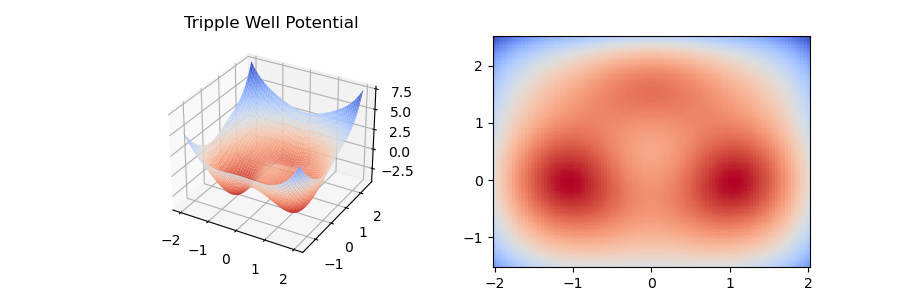

<IPython.core.display.Javascript object>


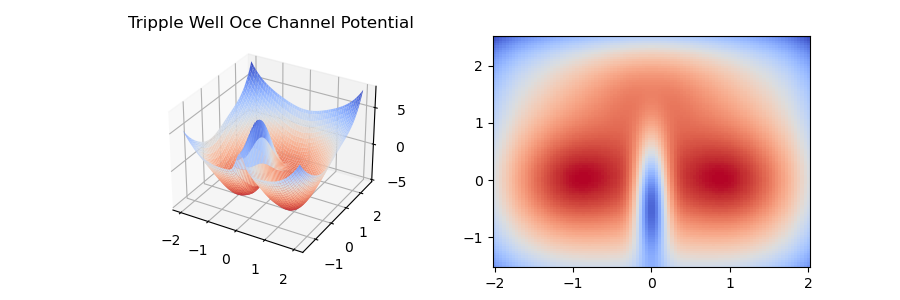

<IPython.core.display.Javascript object>


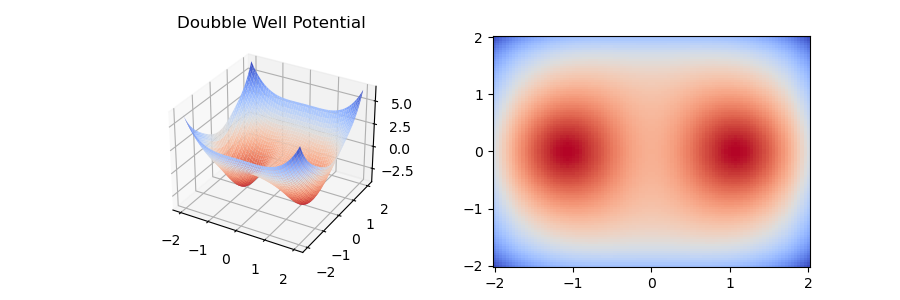

<IPython.core.display.Javascript object>


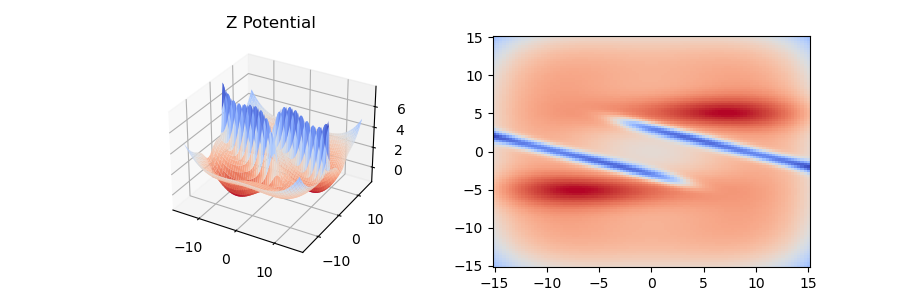

In [10]:
twpot = TripleWellPotential(1)
grid = np.linspace(-2,2,100)
x_plot_tw = np.outer(grid, np.ones(100))
y_plot_tw = np.outer(grid + 0.5, np.ones(100)).T
twpotential_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        twpotential_on_grid[i, j] = twpot.V(np.array([grid[i], grid[j] + 0.5]))

fig0 = plt.figure(figsize=(9,3))
ax0 = fig0.add_subplot(1, 2, 1, projection='3d')
ax1 = fig0.add_subplot(1, 2, 2)
ax0.plot_surface(x_plot_tw, y_plot_tw, twpotential_on_grid,cmap='coolwarm_r', edgecolor='none')
ax0.set_title('Tripple Well Potential')
ax1.pcolormesh(x_plot_tw, y_plot_tw, twpotential_on_grid, cmap='coolwarm_r',shading='auto')

twocpot = TripleWellOneChannelPotential(1)
grid = np.linspace(-2,2,100)
x_plot_tw = np.outer(grid, np.ones(100))
y_plot_tw = np.outer(grid + 0.5, np.ones(100)).T
twocpotential_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        twocpotential_on_grid[i, j] = twocpot.V(np.array([grid[i], grid[j] + 0.5]))

fig1 = plt.figure(figsize=(9,3))
ax0 = fig1.add_subplot(1, 2, 1, projection='3d')
ax1 = fig1.add_subplot(1, 2, 2)
ax0.set_title('Tripple Well Oce Channel Potential')
ax0.plot_surface(x_plot_tw, y_plot_tw, twocpotential_on_grid,cmap='coolwarm_r', edgecolor='none')
ax1.pcolormesh(x_plot_tw, y_plot_tw, twocpotential_on_grid, cmap='coolwarm_r',shading='auto')

dwpot = DoubleWellPotential(1)
grid = np.linspace(-2,2,100)
x_plot_dw = np.outer(grid, np.ones(100))
y_plot_dw = np.outer(grid, np.ones(100)).T
dwpotential_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        dwpotential_on_grid[i, j] = dwpot.V(np.array([grid[i], grid[j]]))
        
fig2 = plt.figure(figsize=(9,3))
ax0 = fig2.add_subplot(1, 2, 1, projection='3d')
ax1 = fig2.add_subplot(1, 2, 2)
ax0.set_title('Doubble Well Potential')
ax0.plot_surface(x_plot_dw, y_plot_dw, dwpotential_on_grid,cmap='coolwarm_r', edgecolor='none')
ax1.pcolormesh(x_plot_dw, y_plot_dw, dwpotential_on_grid, cmap='coolwarm_r',shading='auto')

zwpot = ZPotential(1)
grid = np.linspace(-15,15,100)
x_plot_z = np.outer(grid, np.ones(100))
y_plot_z = np.outer(grid, np.ones(100)).T
zpotential_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        zpotential_on_grid[i, j] = zwpot.V(np.array([grid[i], grid[j]]))
        
fig3 = plt.figure(figsize=(9,3))
ax0 = fig3.add_subplot(1, 2, 1, projection='3d')
ax1 = fig3.add_subplot(1, 2, 2)
ax0.set_title('Z Potential')
ax0.plot_surface(x_plot_z, y_plot_z, zpotential_on_grid,cmap='coolwarm_r', edgecolor='none')
ax1.pcolormesh(x_plot_z, y_plot_z, zpotential_on_grid, cmap='coolwarm_r',shading='auto')


We first define a function 'UnbiasedTraj' to generate an trajectory according an Euler--Maruyama discretization 
$$
X^{n+1} = X^n - \Delta t \nabla V(X^n) + \sqrt{\frac{2 \Delta t}{\beta}} \, G^n 
$$
of the overdamped Langevin dynamics
$$
dX_t = -\nabla V(X_t) \, dt + \sqrt{\frac{2}{\beta}} \, dW_t
$$
This functions takes as argument a potential object, initial conditions, the number of simulation steps and a time step. It generates a realization of a trajectory (subsampled at some prescribed rate), and possibly records the value of the potential energy function at the points along the trajectory.

In [16]:
def UnbiasedTraj(pot, X_0, delta_t=1e-3, T=1000, save=1, save_energy=False, seed=0):
    """Simulates an overdamped langevin trajectory with a Euler-Maruyama numerical scheme 

    :param pot: potential object, must have methods for energy gradient and energy evaluation
    :param X_0: Initial position, must be a 2D vector
    :param delta_t: Discretization time step
    :param T: Number of points in the trajectory (the total simulation time is therefore T * delta_t)
    :param save: Integer giving the period (counted in number of steps) at which the trajectory is saved
    :param save_energy: Boolean parameter to save energy along the trajectory

    :return: traj: np.array with ndim = 2 and shape = (T // save + 1, 2)
    :return: Pot_values: np.array with ndim = 2 and shape = (T // save + 1, 1)
    """
    r = np.random.RandomState(seed)
    X = X_0
    dim = X.shape[0]
    traj = [X]
    if save_energy:
        Pot_values = [pot.V(X)]
    else:
        Pot_values = None
    for i in range(T):
        b = r.normal(size=(dim,))
        X = X - pot.nabla_V(X) * delta_t + np.sqrt(2 * delta_t/pot.beta) * b
        if i % save==0:
            traj.append(X)
            if save_energy:
                Pot_values.append(pot.V(X))
    return np.array(traj), np.array(Pot_values)

We now define the Auto encoders classes and usefull functions for the training

In [17]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, input_dim,bottleneck_dim):
        """Initialise simplest autoencoder (input->bottleneck->ouput), with hyperbolic tangent activation function
       
        :param input_dim: int, Number of dimension of the input vectors
        :param bottleneck_dim: int, Number of dimension of the bottleneck
        """
        super(SimpleAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, bottleneck_dim),
            torch.nn.Tanh()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_dim, input_dim),
        )

    def forward(self, inp):
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded
    
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, bottleneck_dim):
        """Initialise auto encoder with hyperbolic tangent activation function
        You can uncomment certain lines in the encoder and decoder functions to modify the topology of the network
        Make sure when you initialise the AE object that the list 'hidden_dims' has a length consistent with the architecture

        :param input_dim: int, Number of dimension of the input vectors
        :param hidden_dims: list, List of hidden layers
        :param bottleneck_dim: int, Number of dimension of the bottleneck
        """
        super(DeepAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dims[0]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
            torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[1], hidden_dims[2]),
            # torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[2], hidden_dims[3]),
            # torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[3], hidden_dims[4]),
            # torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-1], bottleneck_dim),
            torch.nn.Tanh()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_dim, hidden_dims[-1]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-1], hidden_dims[-2]),
            torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[-2], hidden_dims[-3]),
            # torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[-3], hidden_dims[-4]),
            # torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[-4], hidden_dims[-5]),
            # torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[0], input_dim),
        )

    def forward(self, inp):
        # Input Linear function
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded
    
class AssymmetricAutoEncoder(nn.Module):
    def __init__(self):
        super(AssymmetricAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(2, 1),
            torch.nn.Tanh()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1, 2),
            torch.nn.Tanh(),
            torch.nn.Linear(2, 3),
            torch.nn.Tanh(),
            torch.nn.Linear(3, 4),
            torch.nn.Tanh(),
            torch.nn.Linear(4, 3),
            torch.nn.Tanh(),
            torch.nn.Linear(3, 2),
        )

    def forward(self, inp):
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded

    
def set_learning_parameters(model, learning_rate, loss='MSE', optimizer='Adam'):
    """Function to set learning parameter

    :param model: Neural network model build with PyTorch,
    :param learning_rate: Value of the learning rate
    :param loss: String, type of loss desired ('MSE' by default, another choice leads to L1 loss)
    :param optimizer: String, type of optimizer ('Adam' by default, another choice leads to SGD)

    :return:
    """
    #--- chosen loss function ---
    if loss == 'MSE':
        loss_function = nn.MSELoss()
    else:
        loss_function = nn.L1Loss()
    #--- chosen optimizer ---
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return loss_function, optimizer

def train_AE(model, loss_function, optimizer, traj, weights, num_epochs=10, batch_size=32, test_size=0.2):
    """Function to train an AE model

    :param model: Neural network model built with PyTorch,
    :param loss_function: Function built with PyTorch tensors or built-in PyTorch loss function
    :param optimizer: PyTorch optimizer object
    :param traj: np.array, physical trajectory (in the potential pot), ndim == 2, shape == T // save + 1, pot.dim
    :param weights: np.array, weights of each point of the trajectory when the dynamics is biased, ndim == 1, shape == T // save + 1, 1
    :param num_epochs: int, number of times the training goes through the whole dataset
    :param batch_size: int, number of data points per batch for estimation of the gradient
    :param test_size: float, between 0 and 1, giving the proportion of points used to compute test loss

    :return: model, trained neural net model
    :return: training_data, list of lists of train losses and test losses; one per batch per epoch
    """
    #--- prepare the data ---
    # split the dataset into a training set (and its associated weights) and a test set
    X_train, X_test, w_train, w_test = ttsplit(traj, weights, test_size=test_size)
    X_train = torch.tensor(X_train.astype('float32'))
    X_test = torch.tensor(X_test.astype('float32'))
    w_train = torch.tensor(w_train.astype('float32'))
    w_test = torch.tensor(w_test.astype('float32'))
    # intialization of the methods to sample with replacement from the data points (needed since weights are present)
    train_sampler = torch.utils.data.WeightedRandomSampler(w_train, len(w_train))
    test_sampler  = torch.utils.data.WeightedRandomSampler(w_test, len(w_test))
    # method to construct data batches and iterate over them
    train_loader = torch.utils.data.DataLoader(dataset=X_train,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=train_sampler)
    test_loader  = torch.utils.data.DataLoader(dataset=X_test,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=test_sampler)
    
    #--- start the training over the required number of epochs ---
    training_data = []
    for epoch in range(num_epochs):
        # Train the model by going through the whole dataset
        model.train()
        train_loss = []
        for iteration, X in enumerate(train_loader):
            # Set gradient calculation capabilities
            X.requires_grad_()
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            # Forward pass to get output
            out = model(X)
            # Evaluate loss
            loss = loss_function(out, X)
            # Store loss
            train_loss.append(loss)
            # Get gradient with respect to parameters of the model
            loss.backward()
            # Updating parameters
            optimizer.step()
        # Evaluate the test loss on the test dataset
        model.eval()
        with torch.no_grad():
            test_loss = []
            for iteration, X in enumerate(test_loader):
                out = model(X)
                # Evaluate loss
                loss = loss_function(out, X)
                # Store loss
                test_loss.append(loss)
            training_data.append([torch.tensor(train_loss), torch.tensor(test_loss)])
    return model, training_data

def xi_ae(model,  x):
    """Collective variable defined through an auto encoder model

    :param model: Neural network model build with PyTorch
    :param x: np.array, position, ndim = 2, shape = (1,1)

    :return: xi: np.array
    """
    model.eval()
    x = torch.tensor(x.astype('float32'))
    return model.encoder(x).detach().numpy()

def grad_xi_ae(model, x):
    """Gradient of the collective variable defined through an auto encoder model

    :param model: Neural network model build with pytorch,
    :param x: np.array, position, ndim = 2, shape = (1,1)

    :return: grad_xi: np.array
    """
    model.eval()
    x = torch.tensor(x.astype('float32'))
    x.requires_grad_()
    enc = model.encoder(x)
    grad = torch.autograd.grad(enc, x)[0]
    return grad.detach().numpy()

We define in the next cell an alternative training function to compute and store values for the "variance interpretation" of the training. 

In [19]:
def train_with_variance_decomposition_plots(model,
                                            loss_function,
                                            optimizer,
                                            traj,
                                            weights,
                                            num_epochs=10,
                                            batch_size=32,
                                            test_size=0.2,
                                            n_bins_z=20,
                                            x_domain=[-2, 2],
                                            y_domain=[-1.5, 2.5]
                                           ):
    """Function to train an AE model
    
    :param model: Neural network model built with PyTorch,
    :param loss_function: Function built with PyTorch tensors or built-in PyTorch loss function
    :param optimizer: PyTorch optimizer object
    :param traj: np.array, physical trajectory (in the potential pot), ndim == 2, shape == T // save + 1, pot.dim
    :param weights: np.array, weights of each point of the trajectory when the dynamics is biased, ndim == 1, shape == T // save + 1, 1
    :param num_epochs: int, number of times the training goes through the whole dataset
    :param batch_size: int, number of data points per batch for estimation of the gradient
    :param test_size: float, between 0 and 1, giving the proportion of points used to compute test loss
    :param n_bins_z: integer, number of bins in the z coordinat
    :param x_domain: list, min and max value of x to define the interval of variation of the encoded values
    :param y_domain: list, min and max value of y to define the interval of variation of the encoded values

    :return: model, trained neural net model
    :return: training_data, list of lists of train losses and test losses; one per batch per epoch
    :return: X_given_z, list giving, for each epoch, a list where, for each bin in z, a list of X vectors is provided 
    :return: z_bins, list giving, for each epoch, the list of bins centers in z (correspond to a grid)
    :return: Esp_X_given_z, list giving, for each epoch, a list of averages of X conditioned on z corresponding 
    in each z-bin
    :return: Grad_Esp_X_given_z, list giving, for each epoch, the list of values of nabla xi evaluated 
    at the averages of X conditioned on z
    :return: Std1_X_given_z, list giving, for each epoch, the list of standard deviations of X given z in each z-bin
    :return: Std2_X_given_z, same as above, but with components being the std in each direction
    :return: f_dec_z, list giving, for each epoch, a list of decoded values of z for each z-bin
    """
    #--- prepare the data ---
    # split the dataset into a training set (and its associated weights) and a test set
    X_train, X_test, w_train, w_test = ttsplit(traj, weights, test_size=test_size)
    X_train = torch.tensor(X_train.astype('float32'))
    X_test = torch.tensor(X_test.astype('float32'))
    w_train = torch.tensor(w_train.astype('float32'))
    w_test = torch.tensor(w_test.astype('float32'))
    # intialization of the methods to sample with replacement from the data points (needed since weights are present)
    train_sampler = torch.utils.data.WeightedRandomSampler(w_train, len(w_train))
    test_sampler  = torch.utils.data.WeightedRandomSampler(w_test, len(w_test))
    # method to construct data batches and iterate over them
    train_loader = torch.utils.data.DataLoader(dataset=X_train,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=train_sampler)
    test_loader  = torch.utils.data.DataLoader(dataset=X_test,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=test_sampler)
    
    #--- Prepare empty list to store X given z ---
    X_given_z          = [[[] for i in range(n_bins_z)] for j in range(num_epochs)]
    Esp_X_given_z      = [[np.zeros(2) for i in range(n_bins_z)] for j in range(num_epochs)]
    Grad_Esp_X_given_z = [[np.zeros(2) for i in range(n_bins_z)] for j in range(num_epochs)]
    Std1_X_given_z     = [[np.zeros(1) for i in range(n_bins_z)] for j in range(num_epochs)]
    Std2_X_given_z     = [[np.zeros(2) for i in range(n_bins_z)] for j in range(num_epochs)]
    z_bins = [[] for j in range(num_epochs)]
    f_dec_z = [[np.zeros(2) for i in range(n_bins_z)] for j in range(num_epochs)]
    # --- start the training over the required number of epochs ---
    training_data = []
    for epoch in range(num_epochs):
        # Train the model by going through the whole dataset
        model.train()
        train_loss = []
        for iteration, X in enumerate(train_loader):
            # Set gradient calculation capabilities
            X.requires_grad_()
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            # Forward pass to get output
            out = model(X)
            # Evaluate loss
            loss = loss_function(out, X)
            # Get gradient with respect to parameters of the model
            loss.backward()
            # Store loss
            train_loss.append(loss)
            # Updating parameters
            optimizer.step()
        # Evaluate the test loss on the test dataset and preparation to compute conditional properties
        model.eval()
        # Initialize extremal values of z over data set to determine location of bins
        z_min = 1
        z_max = -1
        with torch.no_grad():
            # Evaluation of test loss
            test_loss = []
            for iteration, X in enumerate(test_loader):
                out = model(X)
                # Evaluate loss
                loss = loss_function(out, X)
                # Store loss
                test_loss.append(loss)
            training_data.append([torch.tensor(train_loss), torch.tensor(test_loss)])
            # Preparation for computation of conditional properties : first bounds on z, then sorting out
            gridx = np.linspace(x_domain[0], x_domain[1],100)
            gridy = np.linspace(y_domain[0], y_domain[1],100)
            xi_ae1_on_grid = np.zeros([100, 100])
            for i in range(100):
                for j in range(100):
                    x = np.array([gridx[i], gridy[j]])
                    z = xi_ae(model, x)
                    # Update z_min and z_max
                    if z > z_max:
                        z_max = z
                    if z < z_min:
                        z_min = z
            dz = np.array((z_max - z_min)/n_bins_z)
            for x in X_train:
                z = model.encoder(x)
                h = int((z - z_min) / dz)
                # remove one point, the one for which z=z_max (in which case h=n_bins_z, out of bounds)
                if (h < n_bins_z):
                    X_given_z[epoch][h].append(x)
        #--- Computation of conditional properties ---
        z_bins[epoch].append((np.linspace(z_min, z_max, n_bins_z)).tolist())
        for j in range(n_bins_z):       
            # test whether there are elements X in the j-th bin, and if yes, compute conditional properties 
            if len(X_given_z[epoch][j]) > 0:
                # transform PyTorch tensors into numpy arrays
                values =  np.array([np.array(X_given_z[epoch][j][0])])
                for i in range(1, len(X_given_z[epoch][j])):
                    values = np.append(values, np.array([np.array(X_given_z[epoch][j][i])]), axis=0)
                # evaluate the various conditional properties    
                Esp_X_given_z[epoch][j] = np.mean(values, axis=0)
                f_dec_z[epoch][j] = model(torch.tensor(Esp_X_given_z[epoch][j].astype('float32'))).detach().numpy()
                Grad_Esp_X_given_z[epoch][j] = grad_xi_ae(model, Esp_X_given_z[epoch][j])
                # first compute the standard deviation in x and y coordinates [axis=0 asks to loop over points X]
                Std2_X_given_z[epoch][j] = np.std(values, axis=(0))
                # we next sum the variances and take the square root
                Std1_X_given_z[epoch][j] = np.sqrt( np.sum(Std2_X_given_z[epoch][j]**2) )
                        
    return model, training_data, X_given_z, z_bins, Esp_X_given_z, Grad_Esp_X_given_z, Std1_X_given_z, Std2_X_given_z, f_dec_z

 ### Data set generation 

In the following box we generate a trajectory in the desired potential with the function previously defined. It will be further used for the AE training. 

<IPython.core.display.Javascript object>


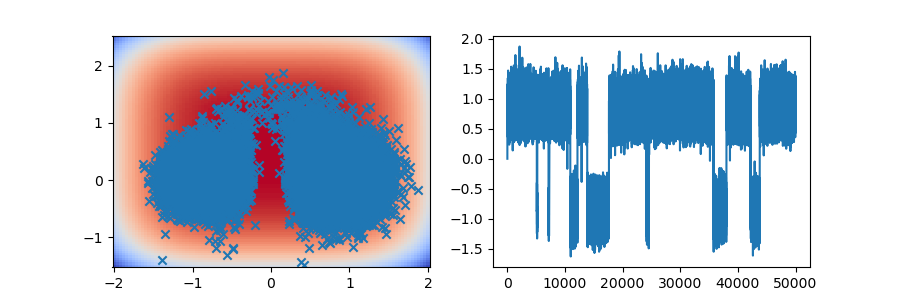

In [14]:
### Parameters 
beta = 2
delta_t = 0.01
T = 500000
save = 10
seed = None 
## Potential can be changed to whatever is defined above, make sure the otgher parameters are changed accordingly
pot = TripleWellOneChannelPotential(beta) 
x_domain = [-2, 2] #we set it here for the coming plots
y_domain = [-1.5, 2.5] #we set it here for the coming plots

x_0 = np.array([0, 1])

### Generate the trajectory
trajectory, _ = UnbiasedTraj(pot, x_0, delta_t=delta_t, T=T, save=save, save_energy=False, seed=seed)


###Compute the potential on the appropriate grid for nice plot
gridx = np.linspace(x_domain[0], x_domain[1], 100)
gridy = np.linspace(y_domain[0], y_domain[1], 100)
x_plot = np.outer(gridx, np.ones(100)) 
y_plot = np.outer(gridy, np.ones(100)).T 
potential_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        potential_on_grid[i, j] = pot.V(np.array([grid[i], grid[j]]))

### Plot the trajectory 
fig = plt.figure(figsize=(9,3))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
ax0.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r', shading='auto')
ax0.scatter(trajectory[:,0], trajectory[:,1], marker='x')
ax1.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')

SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
  )
)


<IPython.core.display.Javascript object>


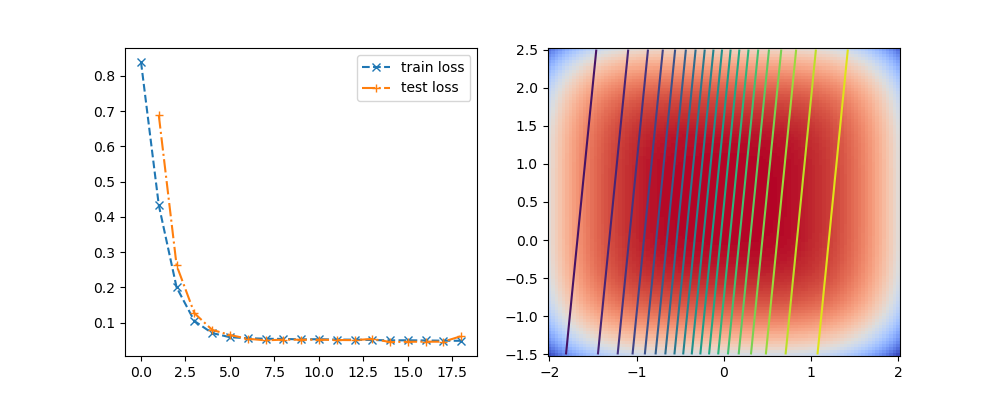

In [20]:
batch_size = 1000
num_epochs = 20
learning_rate = 0.005
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
ae1 = SimpleAutoEncoder(2,1) 
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1, learning_rate=learning_rate)
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 20, cmap = 'viridis')

<IPython.core.display.Javascript object>


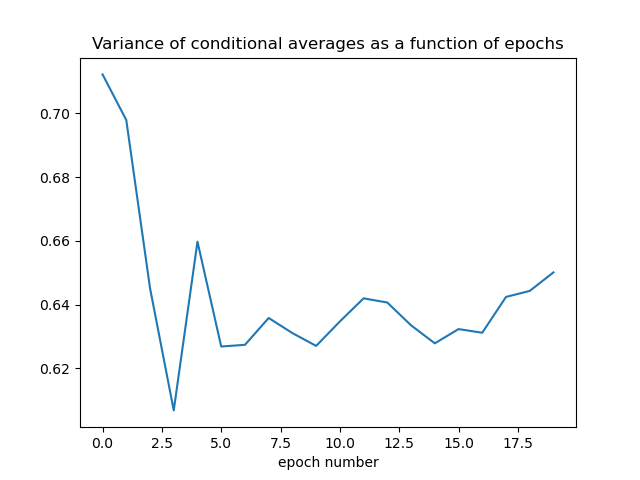

Text(0.5, 0, 'epoch number')

In [22]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')

<IPython.core.display.Javascript object>


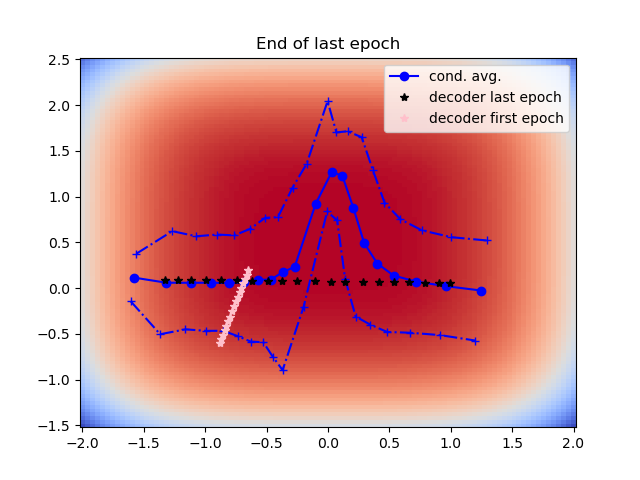

In [23]:
#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

We continue the training, decoder is clearly not optimal. We just copy the cell of the training with commenting the  line which initialises the model 

In [ ]:
batch_size = 1000
num_epochs = 20
learning_rate = 0.005
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
#ae1 = SimpleAutoEncoder(2,1)  ### We don't want  to re-initialise the model here
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1, learning_rate=learning_rate)
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 40, cmap = 'viridis')

In [ ]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')

In [ ]:
#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

This looks better but we a few more epoch would be good to improve it a bit. Here we are limited by the architechture of the AE as the decoder is just an affine function $\mathbb{R} \ to \mathbb{R}²$ so the decoded values must be on a line in the x,y plane so let's try something with a more complex architechture only in the decoder. 

In [ ]:
batch_size = 1000
num_epochs = 10
learning_rate = 0.005
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
ae1 = AssymmetricAutoEncoder() ### We want  to re-initialise the model here see comment below
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1, learning_rate=learning_rate)
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 40, cmap = 'viridis')

In [ ]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')

#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

Decoder is still not optimal, let's do more epochs to see if something happens. 

In [ ]:
batch_size = 1000
num_epochs = 50
learning_rate = 0.005
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
## ae1 = AssymmetricAutoEncoder() ### We don't want  to re-initialise the model here
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1, learning_rate=learning_rate)
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 40, cmap = 'viridis')

In [ ]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')

#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

It seems to be learning something but supper slowly. As the points in the middle part are extremely in minority compared to those in each well, it learns there slowly. I think this behaviour will always show up for transition channels which are numerous times less probable that the "states weels". 

Let's try first to continue the training on only the decoder.

In [ ]:
batch_size = 1000
num_epochs = 10
learning_rate = 0.001
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
 # ae1 = AssymmetricAutoEncoder() ### We don't want  to re-initialise the model here
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1.decoder, learning_rate=learning_rate) ## here we only give the decoder as model to the optimizer.
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 40, cmap = 'viridis')

In [ ]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')
## We should have something constant here as the encoder is supposed to stay the same.


#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

Let's see with more complex encoder.

In [ ]:
batch_size = 1000
num_epochs = 50
learning_rate = 0.005
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
ae1 = DeepAutoEncoder(2, [3, 2], 1) ### We don't want  to re-initialise the model here
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1, learning_rate=learning_rate) ## here we only give the decoder as model to the optimizer.
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 40, cmap = 'viridis')

I would say that the encoder overfitted with the data, it should learn something symmetrical with respect t the y axis. 

In [ ]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')
## We should have something constant here as the encoder is supposed to stay the same.


#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

Maybe the decoder is too simple. Let's try something even deeper.

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, bottleneck_dim):
        """Initialise auto encoder with hyperbolic tangent activation function
        You can uncomment certain lines in the encoder and decoder functions to modify the topology of the network
        Make sure when you initialise the AE object that the list 'hidden_dims' has a length consistent with the architecture

        :param input_dim: int, Number of dimension of the input vectors
        :param hidden_dims: list, List of hidden layers
        :param bottleneck_dim: int, Number of dimension of the bottleneck
        """
        super(DeepAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dims[0]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[1], hidden_dims[2]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[2], hidden_dims[3]),
            torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[3], hidden_dims[4]),
            # torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-1], bottleneck_dim),
            torch.nn.Tanh()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_dim, hidden_dims[-1]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-1], hidden_dims[-2]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-2], hidden_dims[-3]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-3], hidden_dims[-4]),
            torch.nn.Tanh(),
            # torch.nn.Linear(hidden_dims[-4], hidden_dims[-5]),
            # torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[0], input_dim),
        )
        
    def forward(self, inp):
        # Input Linear function
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
batch_size = 1000
num_epochs = 40
learning_rate = 0.005
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
ae1 = DeepAutoEncoder(2, [3, 4, 3, 2], 1) ### We want  to re-initialise the model here
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1, learning_rate=learning_rate) 
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 40, cmap = 'viridis')

This one also has over fitted.

In [ ]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')
## We should have something constant here as the encoder is supposed to stay the same.


#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

Let's try to converge the decoder given this encoder

In [ ]:
batch_size = 1000
num_epochs = 150
learning_rate = 0.001
n_bins_z = 20          # number of bins in the Encoded dimension
optimizer_algo='Adam'  # Adam by default, otherwise SGD
## ae1 = DeepAutoEncoder(2, [3, 3, 2], 1) ### We don't want  to re-initialise the model here
print(ae1) 


#--- First training of the NN ---
loss_function, optimizer = set_learning_parameters(ae1.decoder, learning_rate=learning_rate) ## here we only give the decoder as model to the optimizer.
(
    ae1,
    training_data1,
    X_given_z,
    z_bins,
    Esp_X_given_z,
    Grad_Esp_X_given_z,
    Std1_X_given_z,
    Std2_X_given_z,
    f_dec_z
) = train_with_variance_decomposition_plots(ae1,
                                            loss_function,
                                            optimizer,
                                            trajectory,
                                            np.ones(trajectory.shape[0]),
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            n_bins_z=n_bins_z,
                                            x_domain=x_domain,
                                            y_domain=y_domain
                              )

#--- Compute average losses per epoch ---
loss_evol1 = []
for i in range(len(training_data1)):
    loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
loss_evol1 = np.array(loss_evol1)

#--- Compute things to do "nice" plots ---
# Ort_Grad_Esp_X_given_z is a unit tangent vector to the isoline \xi = cst
# computed by taking the normalized orthogonal to \nabla \xi
Ort_Grad_Esp_X_given_z = [[] for i in range(num_epochs)]
# Conditional average of X plus/minus 1.96*standard deviation in the tangent direction
Esp_p_X_given_z = [[] for i in range(num_epochs)]
Esp_m_X_given_z = [[] for i in range(num_epochs)]
Var_Esp_X_given_z = np.zeros(num_epochs)
for epoch in range(num_epochs):
    j = 0
    # loop over the lists over bins to eliminate empty bins
    while j < len(z_bins[epoch][0]):
        if len(X_given_z[epoch][j]) == 0:
            z_bins[epoch][0].pop(j)
            Esp_X_given_z[epoch].pop(j)
            Grad_Esp_X_given_z[epoch].pop(j)
            Std1_X_given_z[epoch].pop(j)
            Std2_X_given_z[epoch].pop(j) 
            X_given_z[epoch].pop(j)
            f_dec_z[epoch].pop(j)
        else:
            j += 1
    for j in range(len(z_bins[epoch][0])):
        # computation of the tangent vector orthogonal to \nabla \xi = (a_1,a_2), i.e. t = (-a_2,a_1)/normalization
        Ort_Grad_Esp_X_given_z[epoch].append(np.zeros(2))
        Ort_Grad_Esp_X_given_z[epoch][j][0] = - Grad_Esp_X_given_z[epoch][j][1] 
        Ort_Grad_Esp_X_given_z[epoch][j][1] = Grad_Esp_X_given_z[epoch][j][0] 
        Ort_Grad_Esp_X_given_z[epoch][j] = Ort_Grad_Esp_X_given_z[epoch][j] / np.sqrt(np.sum(Grad_Esp_X_given_z[epoch][j]**2))
        # plotting average of X in a bin +/- standard deviation along tangent vector
        Esp_m_X_given_z[epoch].append(Esp_X_given_z[epoch][j] - 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
        Esp_p_X_given_z[epoch].append(Esp_X_given_z[epoch][j] + 1.96 * Std1_X_given_z[epoch][j] * Ort_Grad_Esp_X_given_z[epoch][j])
    Var_Esp_X_given_z[epoch] = np.std(np.array(Esp_X_given_z[epoch]))

# Obtain values of the RC and potential on a grid to plot contour lines
xi_ae1_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = np.array([gridx[i], gridy[j]])
        xi_ae1_on_grid[i,j] = xi_ae(ae1, x)

#--- Plot the results ---
start_epoch_index = 1
fig, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='x')
ax0.plot(range(1, len(loss_evol1[start_epoch_index:, 1])), loss_evol1[start_epoch_index: -1, 1], '-.', label='test loss', marker='+')
ax0.legend()
ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 40, cmap = 'viridis')

In [ ]:
#--- variance of conditional averages ---
plt.figure()
plt.plot(range(num_epochs), Var_Esp_X_given_z)
plt.title('Variance of conditional averages as a function of epochs')
plt.xlabel('epoch number')
## We should have something constant here as the encoder is supposed to stay the same.


#--- Conditionnal expectancy and decoded values ---
index = -1
plt.figure()
plt.title('End of last epoch')
plt.plot(np.array(Esp_X_given_z[index])[:, 0], np.array(Esp_X_given_z[index])[:, 1], '-o', color='b', label='cond. avg.')
plt.plot(np.array(Esp_p_X_given_z[index])[:, 0], np.array(Esp_p_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(Esp_m_X_given_z[index])[:, 0], np.array(Esp_m_X_given_z[index])[:, 1], '-.+', color='b')
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='black', label='decoder last epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
index = 0
plt.plot(np.array(f_dec_z[index])[:, 0], np.array(f_dec_z[index])[:, 1], '*', color='pink', label='decoder first epoch')
plt.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
plt.legend()

It is getting better and better but it is quite difficult still. 